
Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [0]:
%matplotlib inline

# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [39]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
!nvidia-smi

True
0
Sat Sep  7 13:28:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    59W / 149W |    673MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

!unzip "drive/My Drive/Colab Notebooks/torch/dest.zip"
data_dir ='dest'

# !curl https://download.pytorch.org/tutorial/hymenoptera_data.zip --output hymenoptera_data.zip
# !unzip hymenoptera_data.zip
# data_dir = "hymenoptera_data"


Archive:  drive/My Drive/Colab Notebooks/torch/dest77.zip
   creating: dest7/
   creating: dest7/train/
   creating: dest7/train/goo/
  inflating: dest7/train/goo/goo_20190907_203547.jpg  
  inflating: dest7/train/goo/goo_20190907_203553.jpg  
  inflating: dest7/train/goo/goo_20190907_203552.jpg  
  inflating: dest7/train/goo/goo_20190907_203546.jpg  
  inflating: dest7/train/goo/goo_20190907_203550.jpg  
  inflating: dest7/train/goo/goo_20190907_203545.jpg  
  inflating: dest7/train/goo/goo_20190907_203551.jpg  
  inflating: dest7/train/goo/goo_20190907_203555.jpg  
  inflating: dest7/train/goo/goo_20190907_203554.jpg  
  inflating: dest7/train/goo/goo_20190907_203556.jpg  
  inflating: dest7/train/goo/goo_20190907_203557.jpg  
  inflating: dest7/train/goo/goo_20190907_203524.jpg  
  inflating: dest7/train/goo/goo_20190907_203525.jpg  
  inflating: dest7/train/goo/goo_20190907_203522.jpg  
  inflating: dest7/train/goo/goo_20190907_203521.jpg  
  inflating: dest7/train/goo/goo_20190907

In [0]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names, device, dataset_sizes

(['choki', 'goo', 'paa'],
 device(type='cuda', index=0),
 {'train': 80, 'val': 80})

In [0]:
hoge = list(dataloaders['train'])
for x in hoge:
  print(x[0].shape)

hoge = list(dataloaders['val'])
for x in hoge:
  print(x[0].shape)
  


torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4,

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



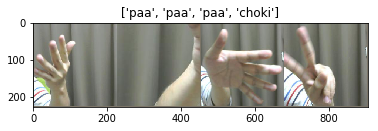

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()



    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
!rm -r ~/.cache/torch

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.






In [0]:
model_ft = models.resnet18(pretrained=True)
# model_ft.cuda() # https://github.com/jwyang/faster-rcnn.pytorch/issues/222
# model_ft = models.resnet50(pretrained=True)

num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [0]:
%time
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.72 µs
Epoch 0/24
----------
train Loss: 1.1352 Acc: 0.4750
val Loss: 0.7293 Acc: 0.7000

Epoch 1/24
----------
train Loss: 0.8322 Acc: 0.6125
val Loss: 0.7404 Acc: 0.6875

Epoch 2/24
----------
train Loss: 0.5735 Acc: 0.7250
val Loss: 0.6030 Acc: 0.7500

Epoch 3/24
----------
train Loss: 0.4957 Acc: 0.7625
val Loss: 1.3849 Acc: 0.6000

Epoch 4/24
----------
train Loss: 0.5463 Acc: 0.7875
val Loss: 0.7251 Acc: 0.7500

Epoch 5/24
----------
train Loss: 0.5971 Acc: 0.7875
val Loss: 1.5766 Acc: 0.6250

Epoch 6/24
----------
train Loss: 0.3301 Acc: 0.8375
val Loss: 0.9620 Acc: 0.7125

Epoch 7/24
----------
train Loss: 0.6308 Acc: 0.7500
val Loss: 0.8055 Acc: 0.7375

Epoch 8/24
----------
train Loss: 0.8188 Acc: 0.6625
val Loss: 0.7456 Acc: 0.7375

Epoch 9/24
----------
train Loss: 0.4228 Acc: 0.8500
val Loss: 0.8676 Acc: 0.7375

Epoch 10/24
----------
train Loss: 0.2677 Acc: 0.9000
val Loss: 0.7307 Acc: 0.7375

Epoch 11/24
----------

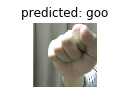

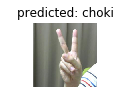

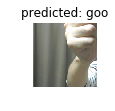

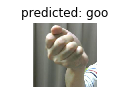

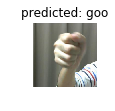

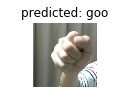

In [0]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
%time
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [0]:
%time
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.63 µs
Epoch 0/24
----------
train Loss: 1.2573 Acc: 0.3000
val Loss: 1.4221 Acc: 0.2375

Epoch 1/24
----------
train Loss: 1.3188 Acc: 0.3750
val Loss: 1.1494 Acc: 0.5000

Epoch 2/24
----------
train Loss: 0.8296 Acc: 0.5500
val Loss: 0.8376 Acc: 0.6250

Epoch 3/24
----------
train Loss: 0.8062 Acc: 0.6875
val Loss: 0.7468 Acc: 0.7000

Epoch 4/24
----------
train Loss: 0.8391 Acc: 0.5875
val Loss: 0.7544 Acc: 0.6750

Epoch 5/24
----------
train Loss: 0.7269 Acc: 0.6875
val Loss: 0.7404 Acc: 0.6875

Epoch 6/24
----------
train Loss: 0.6408 Acc: 0.7625
val Loss: 0.7756 Acc: 0.6750

Epoch 7/24
----------
train Loss: 0.5799 Acc: 0.7000
val Loss: 0.7684 Acc: 0.6875

Epoch 8/24
----------
train Loss: 0.5985 Acc: 0.7250
val Loss: 0.7409 Acc: 0.6875

Epoch 9/24
----------
train Loss: 0.5847 Acc: 0.7375
val Loss: 0.7687 Acc: 0.6750

Epoch 10/24
----------
train Loss: 0.5874 Acc: 0.7500
val Loss: 0.8070 Acc: 0.6750

Epoch 11/24
------

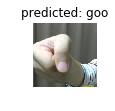

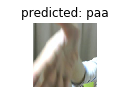

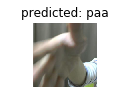

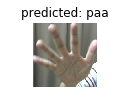

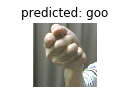

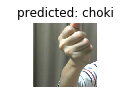

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [0]:
!curl https://www.photolibrary.jp/mhd7/img375/450-20141229110838146588.jpg -o choki.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38378  100 38378    0     0  18612      0  0:00:02  0:00:02 --:--:-- 18612


In [38]:
%time
from PIL import Image

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image = Image.open('choki.jpg')

# dirpath = 'drive/My Drive/Colab Notebooks/torch/3668.jpg'
# image = Image.open(dirpath)

image = data_transform(image).unsqueeze(0).cuda()

out = model_conv(image)
# Find the predicted class
print("Predicted class is: {}".format(class_names[out.argmax()]))

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.58 µs
Predicted class is: paa
